# Uber Trip Analysis - Feature Engineering and Modeling

## Objective
Build machine learning models to forecast daily Uber trips. We will engineer time-series features, train multiple models (Random Forest, XGBoost, Gradient Boosting), and create an ensemble for better performance.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

plt.style.use('ggplot')
%matplotlib inline

## 1. Load Data

In [2]:
df = pd.read_csv('../data_clean/daily_aggregated_trips.csv', parse_dates=['date'], index_col='date')
print(df.head())

            trips  active_vehicles   weekday  is_weekend
date                                                    
2015-01-01  56437             6885  Thursday       False
2015-01-02  39189             6330    Friday       False
2015-01-03  58449             6510  Saturday        True
2015-01-04  40798             5838    Sunday        True
2015-01-05  42752             6884    Monday       False


## 2. Feature Engineering

In [3]:
def create_features(data):
    df_feat = data.copy()
    
    # Date Features
    df_feat['day_of_week'] = df_feat.index.dayofweek
    df_feat['is_weekend'] = (df_feat.index.weekday >= 5).astype(int)
    df_feat['day_of_month'] = df_feat.index.day
    
    # Lag Features (1 day, 2 days, 7 days)
    for lag in [1, 2, 7]:
        df_feat[f'lag_{lag}'] = df_feat['trips'].shift(lag)
    
    # Rolling Statistics (7-day window)
    df_feat['rolling_mean_7'] = df_feat['trips'].shift(1).rolling(window=7).mean()
    df_feat['rolling_std_7'] = df_feat['trips'].shift(1).rolling(window=7).std()
    
    # Holiday Flags
    holidays = pd.to_datetime(['2015-01-01', '2015-01-19', '2015-02-14', '2015-02-16'])
    df_feat['is_holiday'] = df_feat.index.isin(holidays).astype(int)
    
    # Drop NA values created by usage of lags
    df_feat.dropna(inplace=True)
    
    return df_feat

df_features = create_features(df)
print(df_features.head(10))

            trips  active_vehicles    weekday  is_weekend  day_of_week  \
date                                                                     
2015-01-08  71413             7999   Thursday           0            3   
2015-01-09  70296             7989     Friday           0            4   
2015-01-10  78484             7346   Saturday           1            5   
2015-01-11  57026             6571     Sunday           1            6   
2015-01-12  57646             7364     Monday           0            0   
2015-01-13  63499             7559    Tuesday           0            1   
2015-01-14  63329             7849  Wednesday           0            2   
2015-01-15  66729             8080   Thursday           0            3   
2015-01-16  72480             8273     Friday           0            4   
2015-01-17  73363             7527   Saturday           1            5   

            day_of_month    lag_1    lag_2    lag_7  rolling_mean_7  \
date                                    

## 3. Train/Test Split
Using a time-based split. We will take the last 14 days as the test set to simulate short-term forecasting.

In [4]:
test_days = 14
train_data = df_features.iloc[:-test_days]
test_data = df_features.iloc[-test_days:]

X_train = train_data.drop(['trips', 'active_vehicles', 'weekday'], axis=1, errors='ignore')
y_train = train_data['trips']
X_test = test_data.drop(['trips', 'active_vehicles', 'weekday'], axis=1, errors='ignore')
y_test = test_data['trips']

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (38, 9), Test shape: (14, 9)


## 4. Model Training & Evaluation

In [5]:
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
}

results = {}
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    predictions[name] = pred
    
    mape = mean_absolute_percentage_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    results[name] = {'MAPE': mape, 'RMSE': rmse}
    print(f"{name} - MAPE: {mape:.4f}, RMSE: {rmse:.2f}")

RandomForest - MAPE: 0.1231, RMSE: 11804.66


GradientBoosting - MAPE: 0.1012, RMSE: 10084.52


XGBoost - MAPE: 0.1656, RMSE: 15675.32

## 5. Ensemble Model
Weighting models inversely proportional to their MAPE.

In [6]:
# Calculate weights
total_inv_mape = sum([1/res['MAPE'] for res in results.values()])
weights = {name: (1/res['MAPE'])/total_inv_mape for name, res in results.items()}

print("Ensemble Weights:", weights)

# Ensemble Prediction
ensemble_pred = np.zeros_like(y_test, dtype=float)
for name, pred in predictions.items():
    ensemble_pred += pred * weights[name]

ens_mape = mean_absolute_percentage_error(y_test, ensemble_pred)
ens_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
print(f"Ensemble - MAPE: {ens_mape:.4f}, RMSE: {ens_rmse:.2f}")

Ensemble Weights: {'RandomForest': 0.33772845602109014, 'GradientBoosting': 0.41110126995356516, 'XGBoost': 0.2511702740253447}
Ensemble - MAPE: 0.1247, RMSE: 11887.38


## 6. Visualization

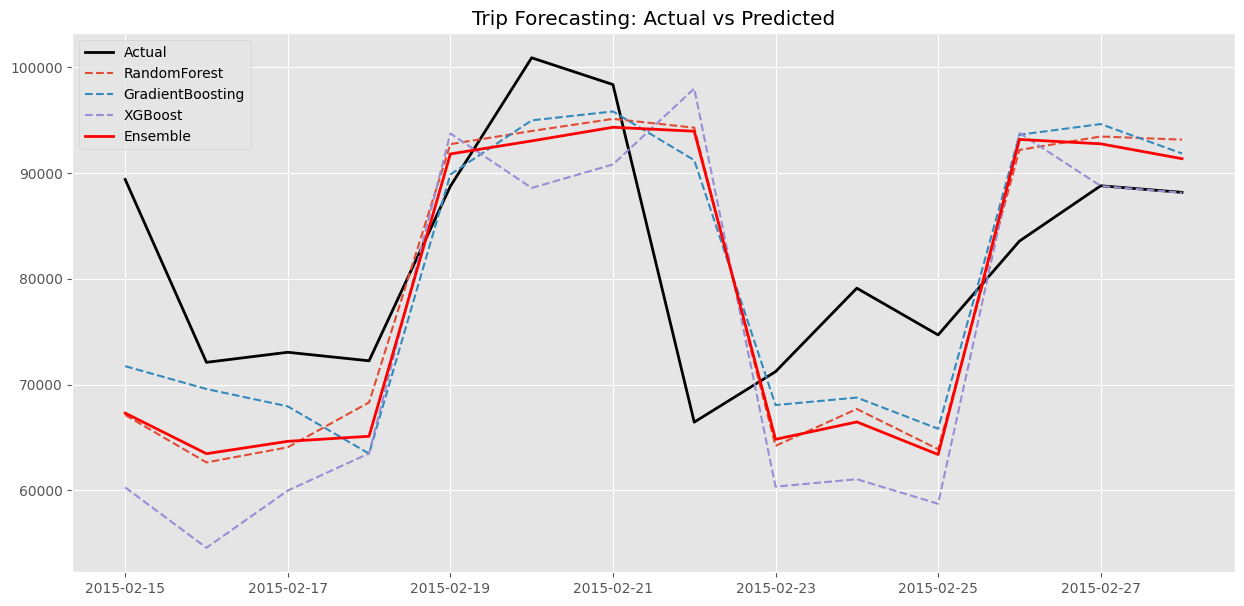

In [7]:
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Actual', color='black', linewidth=2)
for name, pred in predictions.items():
    plt.plot(y_test.index, pred, label=name, linestyle='--')
plt.plot(y_test.index, ensemble_pred, label='Ensemble', color='red', linewidth=2)

plt.title('Trip Forecasting: Actual vs Predicted')
plt.legend()
plt.show()